In [1]:
! pip install pymc

In [2]:
import numpy as np
import pymc as pm
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Generate random data
def generate_data(size):
    x = np.random.randn(size, 2)
    y = np.tanh(x[:, 0] + x[:, 1])
    y = 1. / (1. + np.exp(-(y + y)))
    y = y > 0.5
    return x, y

In [4]:
# Define Variables
iterations = 10000
number_of_samples = 1200

# Define training data
X_train, Y_train = generate_data(100)

In [5]:
# Define neural network
w11 = pm.Normal('w11', mu=0., tau=1.)
w12 = pm.Normal('w12', mu=0., tau=1.)
w21 = pm.Normal('w21', mu=0., tau=1.)
w22 = pm.Normal('w22', mu=0., tau=1.)
w31 = pm.Normal('w31', mu=0., tau=1.)
w32 = pm.Normal('w32', mu=0., tau=1.)

x1 = X_train[:, 0]
x2 = X_train[:, 1]

x3 = pm.Lambda('x3', lambda w1=w11, w2=w12: np.tanh(w1 * x1 + w2 * x2))
x4 = pm.Lambda('x4', lambda w1=w21, w2=w22: np.tanh(w1 * x1 + w2 * x2))


@pm.deterministic
def sigmoid(x=w31 * x3 + w32 * x4):
    return 1. / (1. + np.exp(-x))
y = pm.Bernoulli('y', sigmoid, observed=True, value=Y_train)

# Train the model
model = pm.Model([w11, w12, w21, w22, w31, w32, y])
inference = pm.MCMC(model)
inference.sample(iterations)
y_pred_train = pm.Bernoulli('y_pred_train', sigmoid)

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 10000 of 10000 complete in 4.1 sec

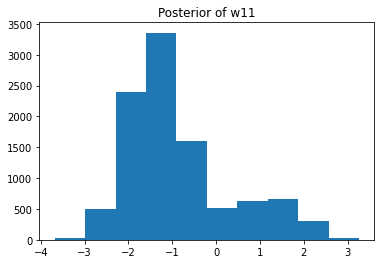

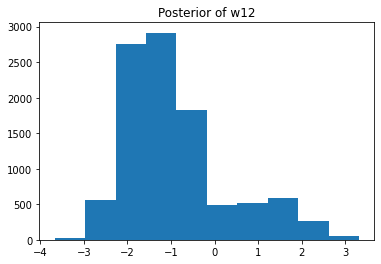

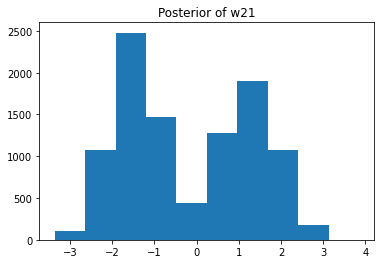

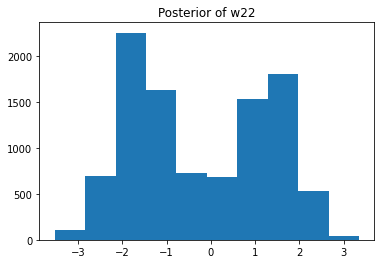

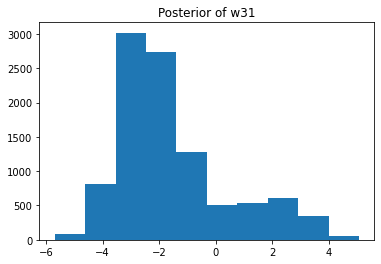

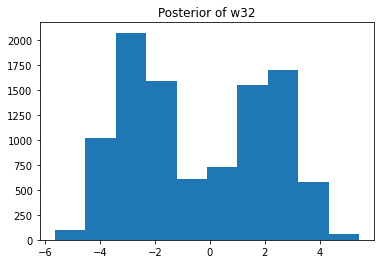

In [6]:
# Plot the values of posterior weight
w11 = inference.trace("w11")[:]
plt.hist(w11)
plt.title('Posterior of w11')
plt.show()

w12 = inference.trace("w12")[:]
plt.hist(w12)
plt.title('Posterior of w12')
plt.show()

w21 = inference.trace("w21")[:]
plt.hist(w21)
plt.title('Posterior of w21')
plt.show()

w22 = inference.trace("w22")[:]
plt.hist(w22)
plt.title('Posterior of w22')
plt.show()

w31 = inference.trace("w31")[:]
plt.hist(w31)
plt.title('Posterior of w31')
plt.show()

w32 = inference.trace("w32")[:]
plt.hist(w32)
plt.title('Posterior of w32')
plt.show()

In [7]:
# Generate test data for evaluation
X_test, Y_test = generate_data(100)

x1 = X_test[:, 0]
x2 = X_test[:, 1]

inference.sample(iterations)
y_pred_test = pm.Bernoulli('y_pred_test', sigmoid)

 [-----------------100%-----------------] 10000 of 10000 complete in 4.3 sec

In [8]:
# Check the accuracy of the training data and the testing data 
print("\nOne sample of weights (w11, w12, w21, w22, w31, w32):\n", w11[-1], w12[-1], w21[-1], w22[-1], w31[-1], w32[-1])
print("Accuracy on train data: ", (y_pred_train.value == Y_train).mean())
print("Accuracy on test data: ", (y_pred_test.value == Y_test).mean())


One sample of weights (w11, w12, w21, w22, w31, w32):
 -1.803473367968266 -2.015820793546361 1.7753129349118821 2.6238833726381823 -2.0068490161402366 0.8543951424217191
Accuracy on train data:  0.92
Accuracy on test data:  0.85
